# 🎯 Calibration and Evaluation Demo

This notebook demonstrates how to use the following post-hoc calibration classes (implemented in pytorch):
- `PlattCalibrator`
- `TemperatureScaling` 
- `DirichletCalibration`
- `TopLabelTemperature`

As well as the `Evaluator` class: The evaluation is designed for **extreme multi-class (thousends of classes) and noisy healthcare data**, where **per-class reliability and performance** is important and **reliable uncertainty quantificaition** is essential for interpretability for automated decision-making.

For demonstration purposes it uses synthetic data that simulates these data complexities. The data generation is implemented in `synthetic_admission_code.py` and demonstrated in `synthetic_admissions_preprocessing.ipynb`. And for its base-model it uses the `SimpleMLP` class from `mlp_classifier.py`.

## Configuration

In [1]:
# import data configuration
from data.config import data_config

# relative imports
from src.uncertainty_aware_diagnosis import(
    ICD10data, 
    SimpleMLP, 
)

# absolute imports
import polars as pl  # type: ignore
import pickle  # type: ignore
from torch.utils.data import DataLoader  # type: ignore
import torch  # type: ignore
from torchmetrics import F1Score, Recall  # type: ignore

# paths
train_csv = data_config['train_csv']
val_csv = data_config['val_csv']
test_csv = data_config['test_csv']
ohe_pkl = data_config['ohe_pkl']
target = data_config['target'] # ICD10 principle diagnosis code

# features
numerical = data_config['numerical_features']
categorical = data_config['categorical_features']
high_cardinality_features = data_config['high_cardinality_features']
use_embedding = False

# variables dataloader
batch_size = 32
shuffle = True
use_subset = True  # use subset of data for faster training
subset_size = 64000

## Load data

In [2]:
# load data
with open(ohe_pkl, "rb") as f:
    ohe_cats = pickle.load(f)

train = ICD10data(
    csv_path=train_csv,
    numerical=numerical,
    categorical=categorical,
    high_card=[],
    target=target,
    dropna=True,
    use_embedding=False,
    ohe_categories=ohe_cats,  # use one-hot encoded categorie of full dataset
)
calibration = ICD10data(
    csv_path=val_csv,
    numerical=numerical,
    categorical=categorical,
    high_card=[],
    target=target,
    dropna=True,
    use_embedding=False,
    ohe_categories=ohe_cats,  # use one-hot encoded categorie of full dataset
    encoder=train.encoder,  # use encoder from training set
    scaler=train.scaler,  # use scalor from train set
)
test = ICD10data(
    csv_path=test_csv,
    numerical=numerical,
    categorical=categorical,
    high_card=[],
    target=target,
    dropna=True,
    use_embedding=False,
    ohe_categories=ohe_cats,  # use one-hot encoded categorie of full dataset
    encoder=train.encoder,  # use encoder from training set
    scaler=train.scaler,  # use scalor from train set
)

input_dim = train.X.shape[1]
output_dim = train.classes.shape[0]

print(f"Number of icd10 classes: {len(train.classes)}")
print(f"(input_dim: {input_dim}, output_dim: {output_dim})")

Number of icd10 classes: 561
(input_dim: 517, output_dim: 561)


In [3]:
# initialize data loaders
if use_subset:
    train.X = train.X[:subset_size]
    calibration.X = calibration.X[:subset_size]
    train.y = train.y[:subset_size]
    calibration.y = calibration.y[:subset_size]

train_loader = DataLoader(train, batch_size=batch_size, shuffle=shuffle)
calibration_loader = DataLoader(calibration, batch_size=batch_size, shuffle=shuffle)

## Start base-model training
- Use Symmetric Cross Entropy loss (see [paper](https://arxiv.org/pdf/1908.06112)), it penalizes model overconfidence and is therefore more effective in learning from noisy training data.
- The `SymmetricCrossEntropyLoss` class is a pytorch implementation defined in `uncertainty-aware-diagnosis.noise_robustness_improvements.py`

In [4]:
# variables MLP
num_epochs = 150
early_stopping_patience = 10
learning_rate = 1e-3
dropout = 0.2
hidden_dim = 256
k_folds = 3

# define model
model = SimpleMLP(
    input_dim=input_dim, hidden_dim=hidden_dim, num_classes=output_dim, dropout=dropout
)
model.fit(
    train, # not dataloader but full dataset
    k_folds=k_folds,
    batch_size=batch_size,
    num_epochs=num_epochs,
    learning_rate=learning_rate,
    early_stopping_patience=early_stopping_patience,
    #single_split=0.7,
    verbose=True,
)

# fit model using validation/calibration set 
# Old implementation
# model.fit_on_val_set(
#     train_loader,
#     calibration_loader,
#     num_epochs=num_epochs,
#     learning_rate=learning_rate,
#     early_stopping_patience=early_stopping_patience,
#     verbose=True,
# )


# predict y, probs, and define y_test
y_pred = model.predict(test.X)
probs_test = model.predict_proba(test.X)
y_test = test.y.numpy()


=== Fold 1/3 ===
Epoch 1/150, Train Loss: 8.6972, Val Loss: 6.4397, F1 Macro: 0.2199, Recall Macro: 0.2303
Epoch 2/150, Train Loss: 6.1470, Val Loss: 5.9536, F1 Macro: 0.3186, Recall Macro: 0.3230
Epoch 3/150, Train Loss: 5.8342, Val Loss: 5.8357, F1 Macro: 0.3673, Recall Macro: 0.3710
Epoch 4/150, Train Loss: 5.7123, Val Loss: 5.7956, F1 Macro: 0.4098, Recall Macro: 0.4175
Epoch 5/150, Train Loss: 5.6298, Val Loss: 5.7864, F1 Macro: 0.4253, Recall Macro: 0.4355
Epoch 6/150, Train Loss: 5.5567, Val Loss: 5.7925, F1 Macro: 0.4201, Recall Macro: 0.4242
Epoch 7/150, Train Loss: 5.5009, Val Loss: 5.8213, F1 Macro: 0.4257, Recall Macro: 0.4329
Epoch 8/150, Train Loss: 5.4372, Val Loss: 5.8493, F1 Macro: 0.4331, Recall Macro: 0.4360
Epoch 9/150, Train Loss: 5.3958, Val Loss: 5.8331, F1 Macro: 0.4462, Recall Macro: 0.4518
Epoch 10/150, Train Loss: 5.3427, Val Loss: 5.8770, F1 Macro: 0.4420, Recall Macro: 0.4475
Epoch 11/150, Train Loss: 5.3106, Val Loss: 5.8733, F1 Macro: 0.4381, Recall Macr

In [5]:
# Convert calibrated probabilities to predicted classes
y_pred_base = torch.argmax(torch.tensor(probs_test), dim=1)

# Initialize metrics
f1_macro = F1Score(task="multiclass", average="macro", num_classes=len(test.classes))
recall_macro = Recall(task="multiclass", average="macro", num_classes=len(test.classes))

# Update metrics with predictions and true labels
f1_macro.update(y_pred_base, test.y)
recall_macro.update(y_pred_base, test.y)

# Compute final values
final_f1 = f1_macro.compute()
final_recall = recall_macro.compute()

# Print results
print("Test scores of the basemodel")
print(f"F1 Macro: {final_f1:.4f}")
print(f"Recall Macro: {final_recall:.4f}")
print("")


Test scores of the basemodel
F1 Macro: 0.4312
Recall Macro: 0.4324



# Post-hoc calibration

In [6]:
# relative imports: calibrators
from src.calibrators import(
    PlattCalibrator,
    TemperatureScaling,
    TopLabelTemperature,
    DirichletCalibration
)

In [7]:
# extract logits on val & test
logits_val = model.predict_logits(calibration.X)  # shape (n_val, n_classes)
logits_test = model.predict_logits(test.X)  # shape (n_test, n_classes)

In [8]:
# get raw logits from the MLP --> for Platt's scaling specifice; other calibrators use logits!
props_val = model.predict_proba(calibration.X)  # shape (n_val, n_classes)
probs_test = model.predict_proba(test.X)  # shape (n_test, n_classes)

## Platt's scaling 
Platt’s scaling is a traditional and simple calibration method for binary classifiers, that can be extended to multi-class settings with a one-versus-the-rest approach. It fits a logistic regression model to the model’s uncalibrated scores to convert them into calibrated probabilities (orignialy design by john Platt for SVMs around the 2000s). It has 2 parameters per-class: a weight and a bias. It is found to be limited in extreme multi-class settings, and degrading both calibration and model performance (in our noisy, extreme multi-class healthcare data from federated sources).

In [8]:
# variables calibrator
C = 0.03
solver = "lbfgs"
log_transform = True

# instantiate & fit the Platt calibrator
platt = PlattCalibrator(C=C, solver=solver, log_transform=log_transform)
platt.fit(props_val, calibration.y.numpy())

# use it to get calibrated probabilities on your test set
probs_platt_calibrated = platt.predict_proba(probs_test)

c:\Users\Lwsja\GitHub\uncertainty-aware-diagnosis\.venv\Lib\site-packages\sklearn\linear_model\_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(
c:\Users\Lwsja\GitHub\uncertainty-aware-diagnosis\.venv\Lib\site-packages\sklearn\linear_model\_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


## Temperature scaling: a reliable baseline

Temperature scaling works by multiplying the neural network’s logits by a single scalar parameter. The scaling parameter is determined by minimizing the
negative log-likelihood on a dedicated calibration set, which significantly reduces miscalibration without altering the model’s predictive performance. Temperature
scaling should provide robust generalization due to its minimal complexity, making it particularly attractive for real-world deployments in extreme multiclass
settings where computational simplicity and stability are essential (Guo et al., 2017; Kull et al., 2019; Rajaraman et al., 2022). Given it is using a single parameter it has a low risk on overfitting, with the limitation of only adjusting confidence, not the class ranking nor class-specific biases. It is found that temerature scaling can be a reliable baseline as it does not degrade model performance (as it only adjusts confidence, not ranking), while it can significantly improve calibration.

In [8]:
# variables calibrator
init_temp = 1.5
lr = 0.1
max_iter = 50

# fit temperature
temp = TemperatureScaling(
  init_temp=init_temp,
  lr=lr,
  max_iter=max_iter,
  device=next(model.parameters()).device
)
temp.fit(logits_val, calibration.y.numpy())

# get calibrated probabilities
probs_temp_calibrated = temp.predict_proba(logits_test)

## Dirichlet calibration: a more flexible multi-class approach

Dirichlet calibration is intentionally designed for multi-class and transforms uncalibrated probabilities into more realistic, better-calibrated probabilities by learning a post-processing function using the Dirichlet distribution. It has three parameters: a weight matrix, a bias vector and a temperature scalar, which together transform the uncalibrated logits via a softmax-like function to produce calibrated probabilities. Therefore it can capture more complex miscalibration than temperature scaling, as it allows class-specific and non-linear adjustment. This comes at the cost of higher risk of overfitting and more required calibration data. It is found that Dirichlet calibration is able to both improve calibration and performance, although temperature scaling could obtain higher calibration.


In [9]:
# variables calibrator
num_classes = logits_val.shape[1]
device = "cpu"

# instantiate & fit the Dirichlet calibrator
dirichlet = DirichletCalibration(num_classes=num_classes, device=device)
dirichlet.fit(logits_val, calibration.y.numpy())

# use it to get calibrated probabilities on your test set
probs_dir = dirichlet.predict_proba(logits_test)

## Top-label calibration

Top-label calibration is a post-hoc calibration method that adjusts the predicted probability only for the top-predicted class (or winning class). Instead of calibrating the full probability distribution across all classes, it focuses only on the confidence of the top guess, therefore it simplifies the calibration problem and makes it fast. This can be desired when you only care about the confidence of the predicted label, not the full distribution, and you have limited calibration data and thus want a simplify the deficult extreme multi-class setting. Limitations (i) Ignores the other class probabilities, so it doesn't correct the full distribution, (ii) it cannot be used if you need well-calibrated probabilities for all classes (e.g., ranking, expected value calculations, multi-label tasks), and (iii) it can give misleading results if the wrong label is top-predicted, since it still calibrates that label as if it were the correct one. All in all, not ideal for automated decision-making in healthcare. Anyhow, an implementation is made and it is findings confirm this reasoning. 

In [12]:
# fit temperature
top_label_temp = TopLabelTemperature(mode="top_label", device=next(model.parameters()).device)
top_label_temp.fit(logits_val, calibration.y.numpy())

# get calibrated probabilities
tl_probs_temp = top_label_temp.predict_proba(logits_test)

# Evaluating calibration

Performance metrics (closer to 1 is better):
- `Macro-F1`: it measures the average F1 score computed independently for each class. It treats all classes equally, regardless of how frequent they are. This avoids bias toward dominant classes, good for balanced performance across classes.
- `Recall`: shows how well each class is detected, especially important in domains where missing a class (i.e. rare diseases) is costly. Good for understanding class-wise sensitivity.

Calibration metrics (smaller is better):
- `Brier score`: measures the mean squared difference between predicted probabilities and true one-hot labels. It combines both confidence and correctness. Good for capturing both accuracy and calibration in one scalar.
- `Confidence Expected Calibration Error` (conf-ECE): measures the average difference between confidence and accuracy, binned by confidence level, across all classes. It detects global miscalibration (i.e. over or underconfidence). Good for overall reliability of predicted confidences.
- `Classwise-ECE`: computes the ECE separately for each class and then averages it. This reveals per-class calibration problems, which is essential when you care about minority or rare classes. Thus good for detecting imbalanced reliability.

This combination:\
(i)   Covers discrimination (via Macro-F1, Recall), \
(ii)  Covers probability quality (via Brier), \
(iii) Covers global and local calibration (Conf-ECE + Classwise ECE)

The reliability diagram:\
It is implemented using `pycalib` and is a visualization tool to assess how well a model's predicted probabilities match the actual outcomes, so how calibrated the model is. You could visualise such a diagram per-class, but given our extreme multi-class setting we show only the winning (or top-ranked) class with the highes probability. The X-ax shows the predicted confidence and the y-ax the observed accuracy for predictions in that confidence range. \
*Interpretation*: a perfectly calibrated model will follow the diagonal line (confidence = accuracy). Above the diagonal is underconfident and below is overconfident model estimations. 


In [10]:
# relative imports: calibration evaluator
from src.calibrators import Evaluator


====== Classification Metrics ======

Model               F1 Macro          Recall          Brier
---------------------------------------------
Baseline              0.4312          0.4324          0.2934
Temp                  0.4312          0.4324          0.2243
Dirichlet             0.4508          0.4778          0.2452

====== Calibration (Expected Calibration Error) Metrics ======

Model               conf_ECE              classwise_ECE
---------------------------------------------
Baseline              0.2930                        0.0011
Temp                  0.1064                        0.0006
Dirichlet             0.1777                        0.0008

====== Reliability Diagram ======



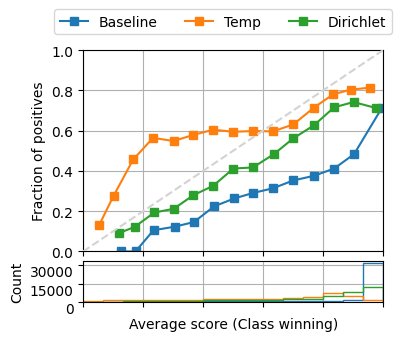

In [11]:
# Instantiate the evaluator
num_classes = len(test.classes)
evaluator = Evaluator(num_classes=num_classes)

# Prepare the dictionary of model outputs
bins = 15 # used for ECE
prob_dict = {
    "Baseline": probs_test,
    #"Platt": probs_platt_calibrated,
    "Temp": probs_temp_calibrated,
    "Dirichlet": probs_dir,
}

# Evaluate everything: prints F1, Recall, Brier, ECE, and shows plot
results, ece_scores = evaluator.evaluate_all(
    y_true=test.y,
    prob_dict=prob_dict,
    bins=bins 
)

Save model and optimizer

In [13]:
import copy

version = "0.1"

best_model_state = copy.deepcopy(model.state_dict())
optimizer_state = copy.deepcopy(model.optimizer.state_dict())
torch.save(best_model_state, f"./data/model_{version}.pth")
torch.save(optimizer_state, f"./data/optimizer_{version}.pth")

# Curriculum learning
Curriculum learning trains models by first exposing them to easy examples, then gradually increasing task difficulty as learning progresses (similar to and inspired by human learning). It improves training stability and generalization (by avoiding early overfitting on hard/noisy samples).
- Decide in what order to train on labeled samples
- Use a curriculum-aware dataloader (Pytorch), that dynamically adjusts based on model confidence.

### How do we define sample difficulty and the training schedule?
| Criterion                      | Description                         | Notes                          |
| ------------------------------ | ----------------------------------- | ------------------------------ |
| **Model confidence**           | High confidence = easy, low = hard  | Use calibrated probs           |
| **MC variance**                | Low variance = easy                 | Epistemic uncertainty          |
| **Loss**                       | Low loss = easy                     | Can be noisy early in training |

- A simple effective way is to define dificulty as `1 - model_confidence`
- Then bin samples into difficulty levels and start by training only on easy samples. Gradually increase max difficulty (per epoch or based on model plateau).


## Steps
1. Train the baseline model on all data, because we need reasonable weights before confidence estimates are meaningful.
2. Fit the calibrator on a held-out calibration set (5-10%) (or cross-validated but additional complexity), to obtain calibrated confidence scores
3. Score dificulty for each sample: `1 - calibrated confidence scores` 
4. Start training, but using curriulum data scheduling (in order of increasing difficulty)

In [ ]:
from uncertainty_aware_diagnosis import CurriculumSampler, plot_curriculum_schedule
from uncertainty_aware_diagnosis import SymmetricCrossEntropyLoss

In [23]:
# load model
model_path = "./data/model_0.1.pth"
model = SimpleMLP(input_dim=input_dim, hidden_dim=hidden_dim, num_classes=num_classes)
model.load_state_dict(torch.load(model_path)) 
# load and reuse optimizer
optimizer_path = "./data/optimizer_0.1.pth"
model.optimizer.load_state_dict(torch.load(optimizer_path))

# instantiate & fit the Dirichlet calibrator
logits_cal = model.predict_logits(calibration.X)  # shape (n_val, n_classes)
dirichlet = DirichletCalibration(num_classes=logits_cal.shape[1], device="cpu")
dirichlet.fit(logits_cal, calibration.y.numpy())

In [ ]:
# compute difficulties
model.eval()
with torch.no_grad():
    logits_train = model.predict_logits(train.X)     

probs_calibr = dirichlet.predict_proba(logits_train)
conf_train = probs_calibr.max(axis=1)
difficulties = 1.0 - torch.tensor(conf_train, dtype=torch.float32)

In [71]:
# curriculum parameters
init_tau = 0.3
delta_tau  = 0.1
plateau_patience   = 5
plateau_margin = 1e-4
early_stopping_patience = 10
max_epochs = 150
continue_training = True

# initialize curriculum loader
curriculum_sampler = CurriculumSampler(difficulties, init_tau)
train_curriculum_loader = DataLoader(train, batch_size=batch_size, sampler=curriculum_sampler)

In [ ]:
# Start a new model from scratch, but use the same difficulty schedule
curriculum_model = SimpleMLP(
    input_dim=input_dim,
    hidden_dim=hidden_dim,
    num_classes=num_classes,
    device=str(device)
).to(device)

# Reinitialize the optimizer
curriculum_model.optimizer = torch.optim.Adam(curriculum_model.parameters(), lr=1e-3)

if continue_training:
    curriculum_model.load_state_dict(torch.load(model_path))
    curriculum_model.optimizer.load_state_dict(torch.load(optimizer_path))

# noise robust loss function
criterion = SymmetricCrossEntropyLoss()
# per-class performance metric
metric_f1 = F1Score(task="multiclass", average="macro", num_classes=num_classes).to(device)

# Curriculum-aware training loop (keeps optimiser state)
best_val = -1.0
best_val_epoch = -1.0
epochs_no_improve = 0
tau = init_tau
tau_maxed_epoch = None  # Track when τ reached 1.0

# logging scores and tau values for visualization
f1_scores: list[float] = []
tau_values: list[float] = []

for epoch in range(max_epochs):
    # training
    curriculum_model.train()
    for xb, yb in train_curriculum_loader:
        xb, yb = xb.to(device), yb.to(device)
        curriculum_model.optimizer.zero_grad()
        logits = curriculum_model(xb)
        loss = criterion(logits, yb)
        loss.backward()
        curriculum_model.optimizer.step()

    # validation
    curriculum_model.eval()
    metric_f1.reset()
    with torch.no_grad():
        for xb, yb in calibration_loader:
            xb, yb = xb.to(device), yb.to(device)
            preds = curriculum_model(xb).argmax(dim=1)
            metric_f1.update(preds, yb)
    val_f1 = metric_f1.compute().item()
    print(f"Epoch {epoch:02d} | τ={tau:.2f} | val-F1={val_f1:.4f}")

    #  logging 
    f1_scores.append(val_f1)
    tau_values.append(tau)

    if val_f1 > best_val + plateau_margin:
        best_val = val_f1

    #  plateau detection 
    if val_f1 > best_val_epoch + plateau_margin:
        best_val_epoch = val_f1
        epochs_no_improve = 0
    else:
        epochs_no_improve += 1
        if epochs_no_improve >= plateau_patience and tau < 1.0:
            tau = min(1.0, tau + delta_tau)  # expose harder samples
            curriculum_sampler.set_tau(tau)
            train_curriculum_loader = DataLoader(
                train, batch_size=batch_size, sampler=curriculum_sampler
            )
            epochs_no_improve = 0
            best_val_epoch = -1.0
            if tau == 1.0:
                tau_maxed_epoch = epoch

    # early stopping after τ = 1.0 
    if tau == 1.0 and tau_maxed_epoch is not None:
        if epoch - tau_maxed_epoch >= early_stopping_patience:
            print(f"Early stopping triggered at epoch {epoch} (τ = 1.0 for {early_stopping_patience}+ epochs)")
            break

Epoch 00 | τ=0.30 | val-F1=0.3977


### Curriculum-aware dataloader that adapts based on model plateau 
- The variable `tau` defines the maximum allowed difficulty of samples used for training.
- `difficulty = 1 − calibrated confidence`, so tau = 0.3 means only "easy" examples (confidence >= 0.7) are used.
- After every epoch, the model is evaluated, if the model fails to improve by more than a `plateau_margin` for `plateau_patience` epochs, then tau is updated and the curriculum gets harder: `tau = min(1.0, tau + delta_tau)`


In [69]:
fig = plot_curriculum_schedule(
    f1_scores=f1_scores,
    tau_values=tau_values,
    title="Tau schedule vs. Validation F1",
    #save_path=Path("figures/demo_curriculum.png"), 
)

### Evaluate Curiculum learning improvement

In [67]:
# calibrate new model
curriculum_model.eval()
logits_cal = curriculum_model.predict_logits(calibration.X)  # shape (n_val, n_classes)
dirichlet = DirichletCalibration(num_classes=logits_cal.shape[1], device=device)
dirichlet.fit(logits_cal, calibration.y.numpy())

# compute test probs with new model
with torch.no_grad():
    logits_train = curriculum_model.predict_logits(test.X)     

if continue_training:
    probs_curiculum = dirichlet.predict_proba(logits_train)
else:
    probs_curiculum_new = dirichlet.predict_proba(logits_train)


====== Classification Metrics ======

Model               F1 Macro          Recall          Brier
---------------------------------------------
Baseline              0.4508          0.4778          0.2452
Curiculum             0.4321          0.4466          0.2722
Curiculum (new)       0.4418          0.4579          0.2594

====== Calibration (Expected Calibration Error) Metrics ======

Model               conf_ECE              classwise_ECE
---------------------------------------------
Baseline              0.1777                        0.0008
Curiculum             0.2415                        0.0010
Curiculum (new)       0.2215                        0.0009

====== Reliability Diagram ======



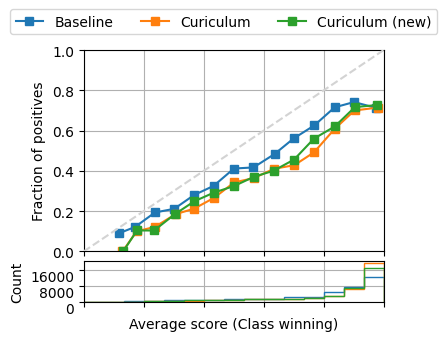

In [ ]:
# Instantiate the evaluator
num_classes = len(test.classes)
evaluator = Evaluator(num_classes=num_classes)

# Prepare the dictionary of model outputs
bins = 15 # used for ECE
prob_dict = {
    "Baseline": probs_dir,
    "Curiculum": probs_curiculum,
    "Curiculum (new)": probs_curiculum_new,
}

# Evaluate everything: prints F1, Recall, Brier, ECE, and shows plot
results, ece_scores = evaluator.evaluate_all(
    y_true=test.y,
    prob_dict=prob_dict,
    bins=bins 
)

# Active learning

Standard uncertainty-based sampling might fail with noise, because Uncertainty ≠ informativeness: Noisy or mislabeled examples tend to have high uncertainty, but the model doesn’t learn useful decision boundaries from them.

Possible approaches:
- Uncertainty sampeling with confidence thresholding (simple but fragile to noise): Instead of just choosing the top-k most uncertain, select examples in a mid-range of uncertainty (not max uncertainty). This avoids both overconfident easy cases and highly noisy uncertain ones.
- Monte Carlo Dropout (still quite simple and more informative): Use MC dropout to estimate uncertainty due to model parameters (epistemic uncertainty), not noise (aleatoric). Focus on samples with high variance in predictions across dropout passes. This avoids many noisy points, because noise yields high entropy but low variance. Inspired by: ensemble Disagreement (Query-by-Committee), which trains an ensemble and select examples where committee members disagree most.
-  diversity-based samplin (more diverse sampeling, but complex modeling): Instead of using uncertainty, select diverse samples via clustering or embedding-space distance (e.g. KMeans in feature space). This doesnt rely on model confidence at all and therefore is more robust against label noise.
- Loss prediction / learning-to-reweight: Train a small auxiliary model to predict label quality. Use this to ignore high-loss examples during sampling. Related to co-teaching frameworks (method for DL with label noise).
- Approaches can be combined: (1) Filter out high-entropy samples / select samples with a model confidence between 0.7 and 0.5, (2) rank remaining by MC Dropout variance, and (3) select a diverse subset (e.g., via k-means clustering or KNN sparsity)

### Goals for your active learning strategy:
1. Avoid selecting noisy samples (reduce wasted budget)
2. Handle class imbalance (don’t oversample majority classes)
3. Account for domain heterogeneity (ensure coverage of different data subpopulations)

### Step 1: select informative samples (just below 70% confidence and high variance)
- Compute predicted confidence and MC Dropout variance (+20 forward passes).
- Filter out: high confidence (>70%) and extremely low confidence (<30% ?) and low variance (likely aleatoric/noise) 

In [ ]:
# model.mc_predict_proba(X)

### Step 2: control for class imbalance to ensure that rare classes don’t get ignored, or even get additional focus
- Stratified sampling: sample K admissions per predicted-class, and potentially limiting the scope further to classes that are just below the performance threshold for usage in practice (below 80% class performance on test data). 
- potentially combine with class-imbalanced reweighting to help the model learn better once you add the new samples.


### Step 3: Ensure diversity across the label space
- Compute distance to existing labeled set or clustering diversity to guarantee wide coverage.

### Step 4: Score and select samples using combined criteria
- build a acquisition function: \
`score = alpha * epistemic_uncertainty + beta * diversity_score + gamma * class_balance_weight`\
where:
  - `epistemic_uncertainty` = MC Dropout variance
  - `diversity_score` = distance to existing labeled set or clustering diversity
  - `class_balance_weight` = inverse frequency of predicted class and 0 for classes that are good enough
- Then sample K admisions for expert review

# Abstaining classifier 
When the model has the option to predict a "I don't know" label, it detects unsure sampels and avoids training on it (different as selective classification, where these samples are used for training but not accepted as prediction).
(see [github of this paper](https://github.com/thulas/dac-label-noise))
 